In [1]:
import os
import math
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.
c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

## LSTM  Model

In [2]:
# ye model bnega jitna mai samajh paya config file se
model = Sequential()
model.add(LSTM(64, input_shape=(10, 4), return_sequences=True ))
model.add(Dropout(1))
model.add(LSTM(64, return_sequences=True))
model.add(GRU(128 ,return_sequences=True ))
model.add(Dropout(1))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear', use_bias=True))
model.summary()
model.compile(loss='mse', optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            17664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
gru_1 (GRU)                  (None, 10, 128)           74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [3]:
def train(model, x, y, epochs, batch_size):
       
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
        
        callbacks = [ EarlyStopping(monitor='val_loss', patience=2), ]
        model.fit(x , y, epochs=epochs, batch_size=batch_size, callbacks=callbacks )
        timer.stop()

In [4]:
def predict_point_by_point(model, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting Point-by-Point...')
        predicted = model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

In [5]:
def plot_results(predicted_data, true_data , title="" ):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()

W1109 21:52:33.686491 22604 deprecation_wrapper.py:119] From c:\users\vishesh jain\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



513
513
[Model] Predicting Point-by-Point...
loss  [3.43791307]


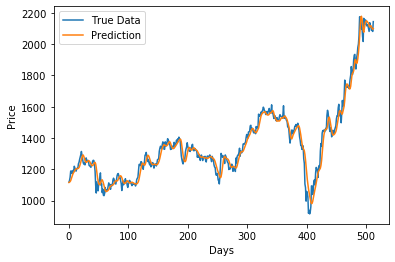

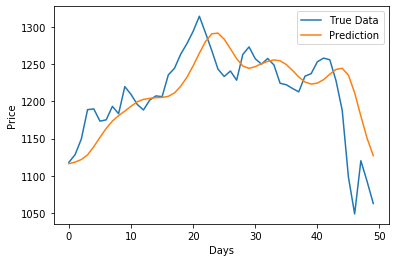

In [6]:
lossesMINE = []
lossesKERAS = []
split_ratio = 0.9
day_prediction = 10

x = np.load("data/train_x.npy")
y = np.load("data/test_y.npy")

length_of_train = int(len(x)*split_ratio)

x_train = x[: length_of_train]
y_train = y[:length_of_train]

Is_trained = True
if Is_trained == False :
    train( model, x_train, y_train , 25 , 256 )
else :
    model.load_weights("output/lstmg10/model.h5")

x_test = x[length_of_train:]
y_test = y[length_of_train :-1]

print(len(x_test))
print(len(y_test))

predictions = predict_point_by_point(model , x_test)
npPredictions = np.asarray(predictions)

loss = 0
for i in range(len(npPredictions)):
    loss += (npPredictions[i] - y_test[i])**2
print("loss ",loss)


## standardization to real data
mean = np.load("data/mean.npy")[3]
std =np.load("data/std.npy")[3]


real_y = np.reshape(y_test, (y_test.shape[0], ))*std + mean
real_pred = predictions*std +mean

plot_results(real_pred, real_y)
plot_results(real_pred[:50], real_y[:50])

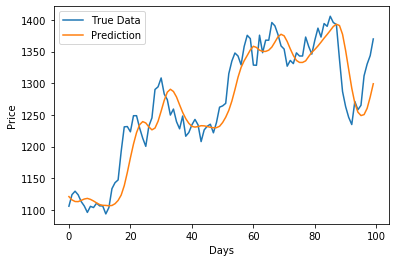

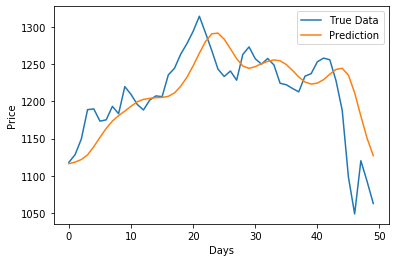

In [7]:
plot_results(real_pred[100:200], real_y[100:200])
plot_results(real_pred[:50], real_y[:50])

In [10]:
import random

In [11]:
from numpy import newaxis
def predict_multiple_days(model ,data  , days_to_predict , seq_len , y_actual ):
    print('[Model] Predicting Sequences Multiple...')
    loss = []
    prediction_seqs = []
    y_actaul_seqs =[]

    for i in range(len(data) - days_to_predict-350):
            print(i)
            curr_frame = data[i]
            #print("frame  ",curr_frame)
            predicted = []
            loss_temp = []
            actual =[]
            for j in range(days_to_predict):
                #print("frame  ",curr_frame)
                #print("new Axis",newaxis)
                predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0] )
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, seq_len-1, predicted[-1] + random.uniform(-0.05 , 0.05), axis=0)
                loss_temp.append((y_actual[i+j][0] - predicted[-1] )**2)
                actual.append(y_actual[i+j][0])
            loss.append(loss_temp)
            y_actaul_seqs.append(actual)
            prediction_seqs.append(predicted)
    return prediction_seqs , loss , y_actaul_seqs

In [12]:
prediction_seqs , loss , y_actual = predict_multiple_days(model,x_test , 50 , 10 , y_test)

[Model] Predicting Sequences Multiple...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


0


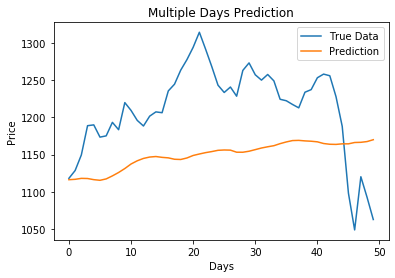

1


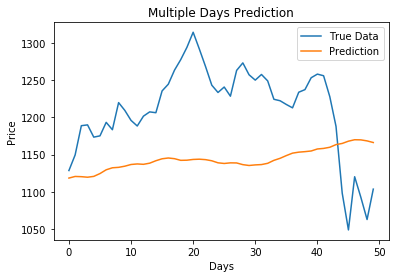

2


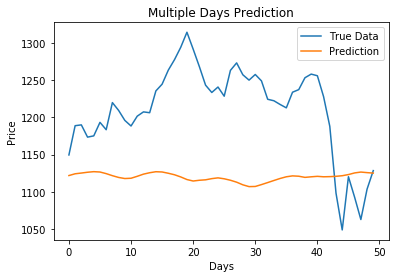

3


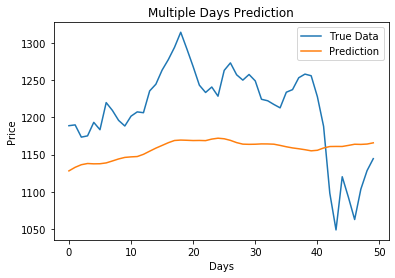

4


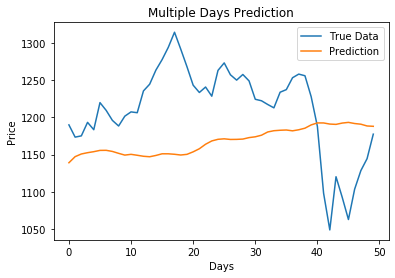

5


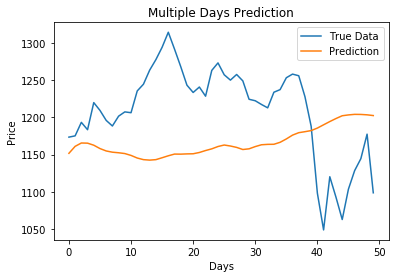

6


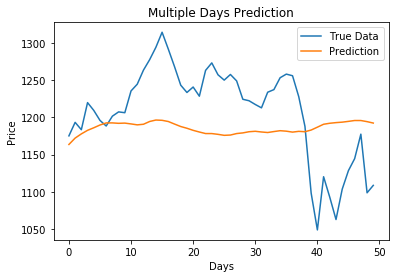

7


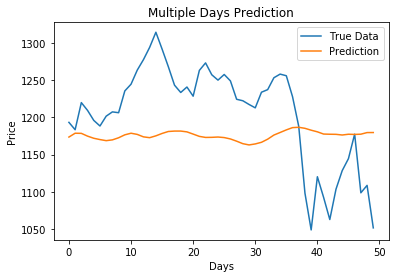

8


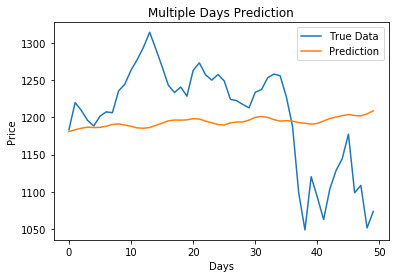

9


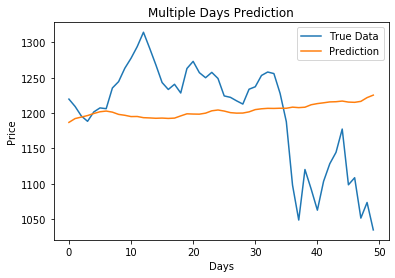

10


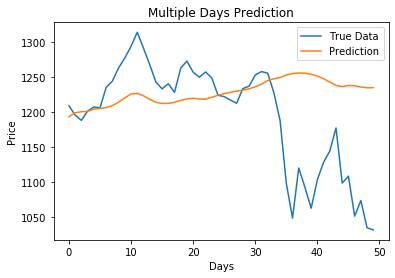

11


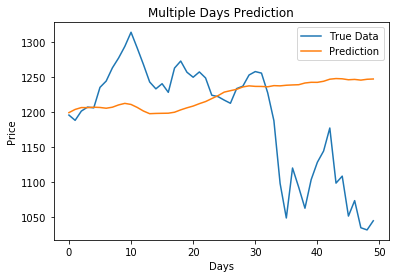

12


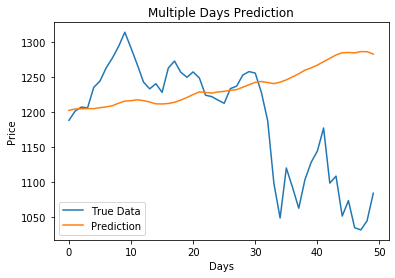

13


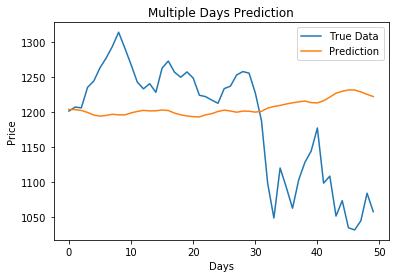

14


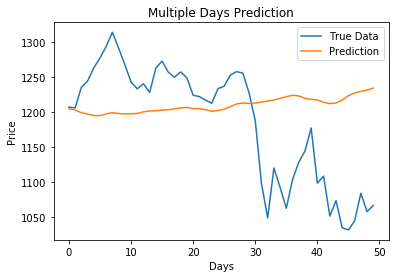

15


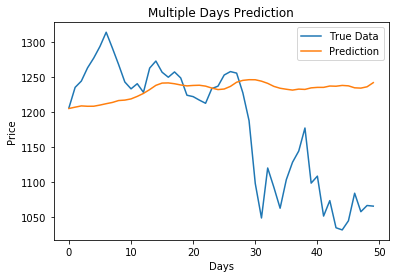

16


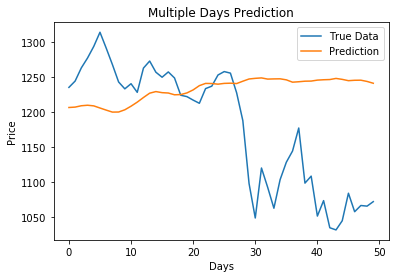

17


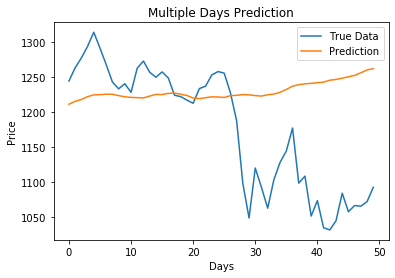

18


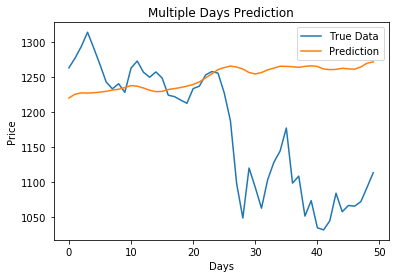

19


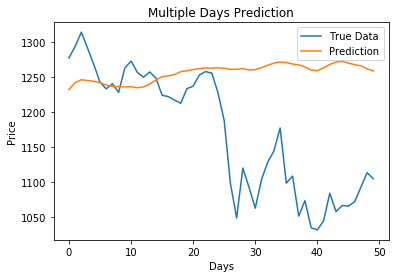

20


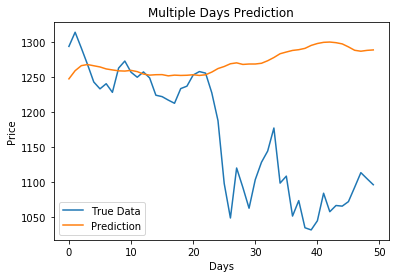

21


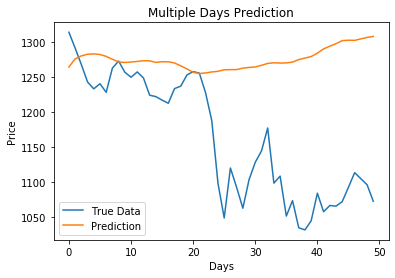

22


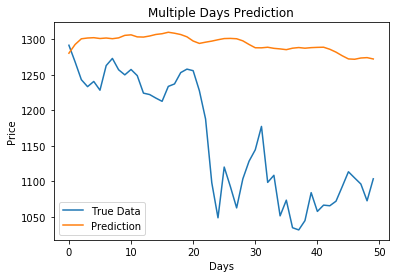

23


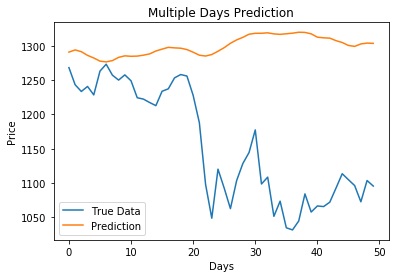

24


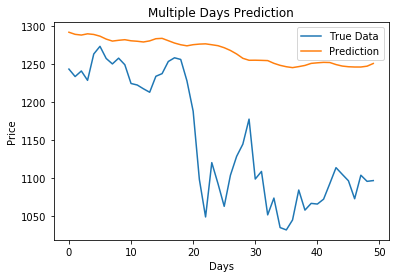

25


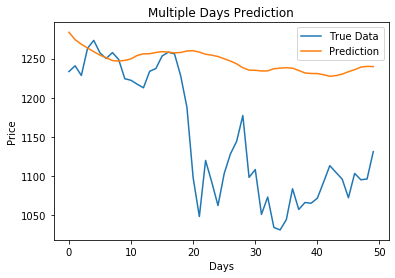

26


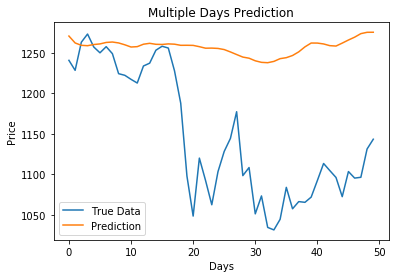

27


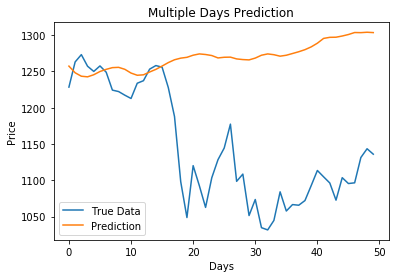

28


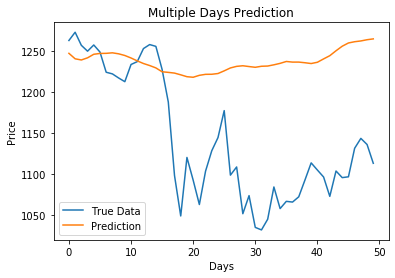

29


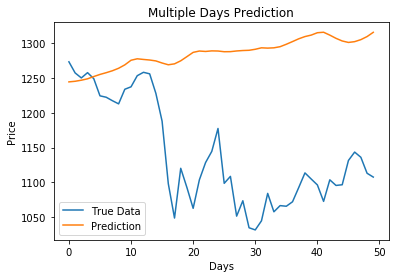

30


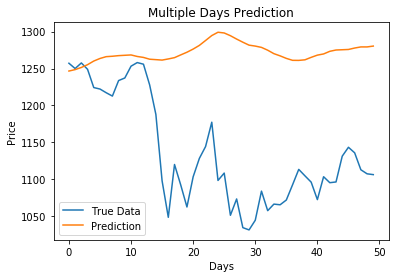

31


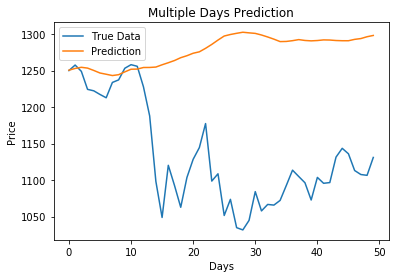

32


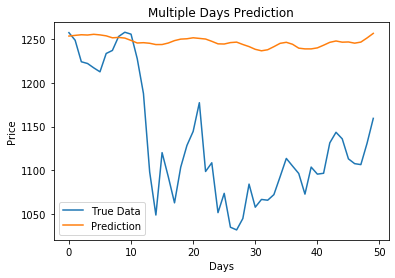

33


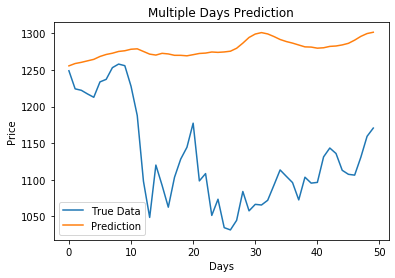

34


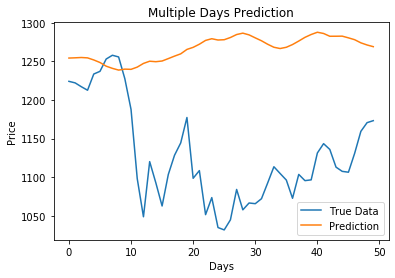

35


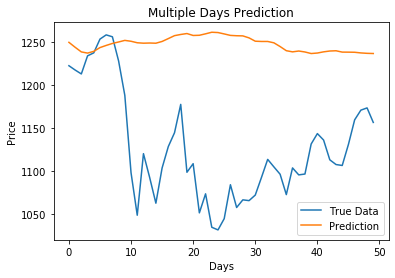

36


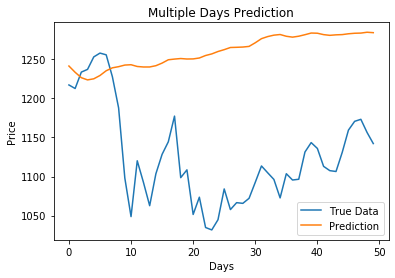

37


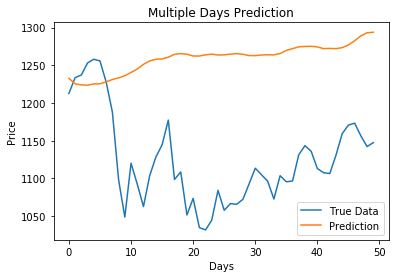

38


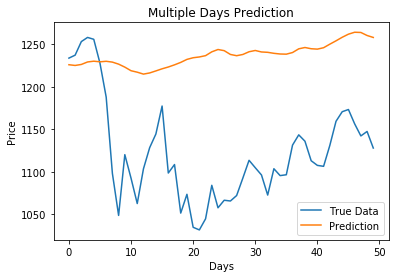

39


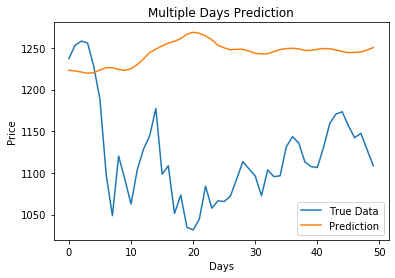

40


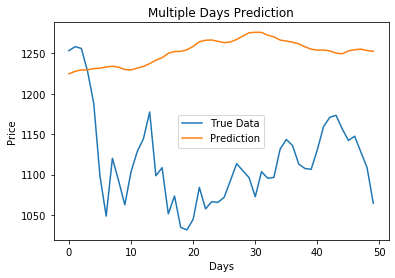

41


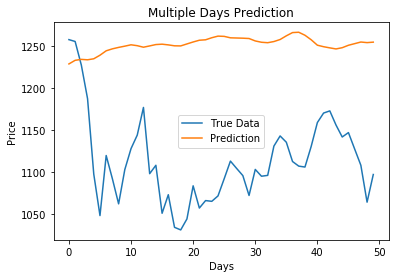

42


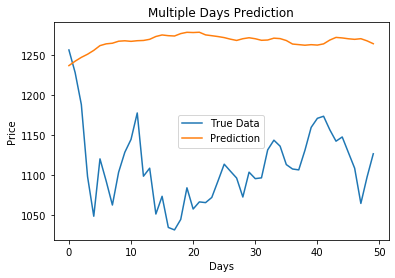

43


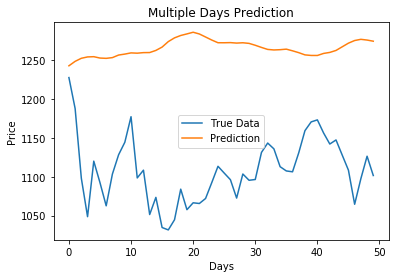

44


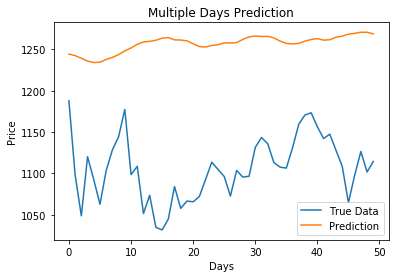

45


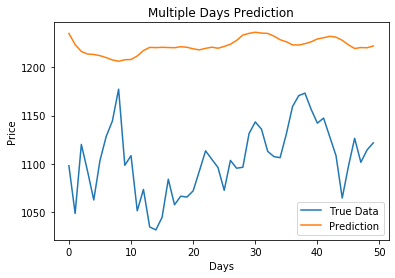

46


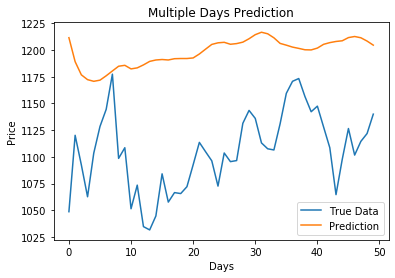

47


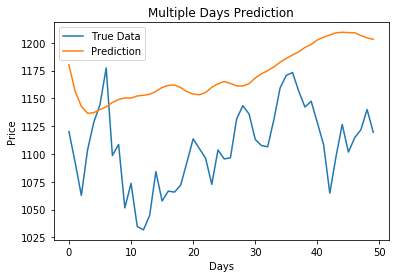

48


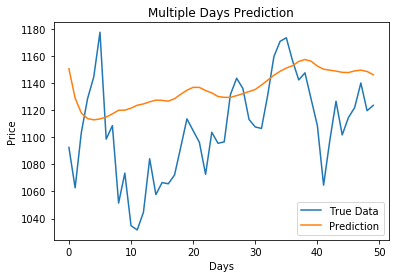

49


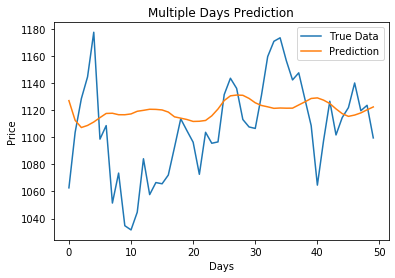

50


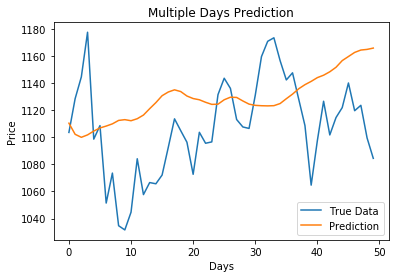

51


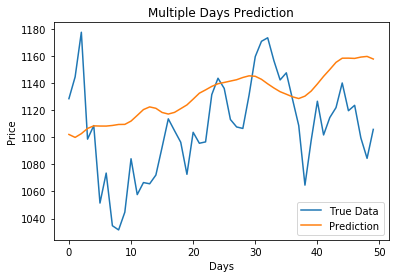

52


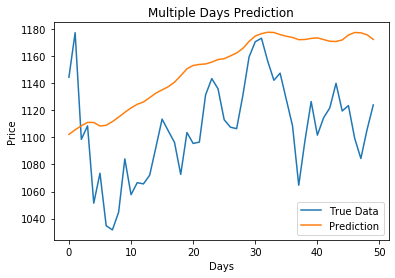

53


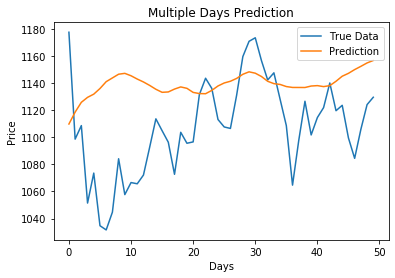

54


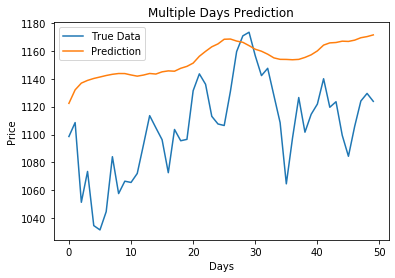

55


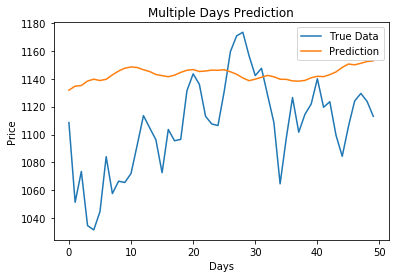

56


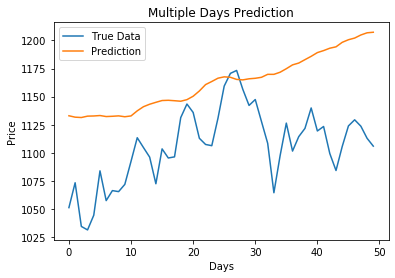

57


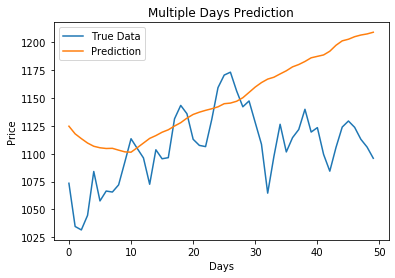

58


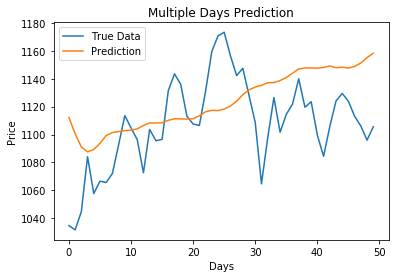

59


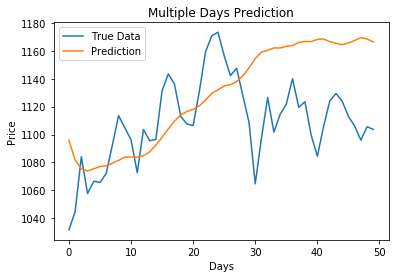

60


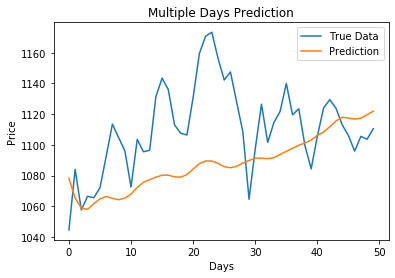

61


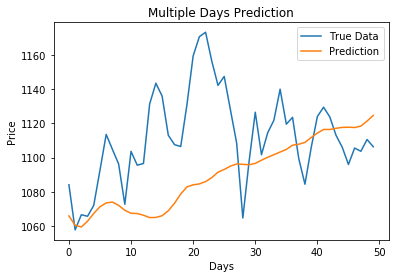

62


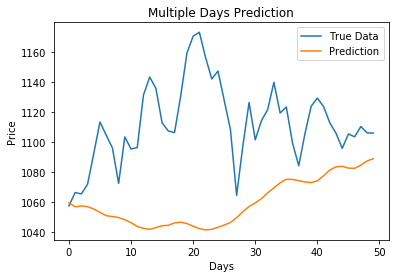

63


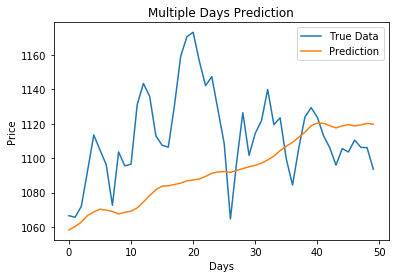

64


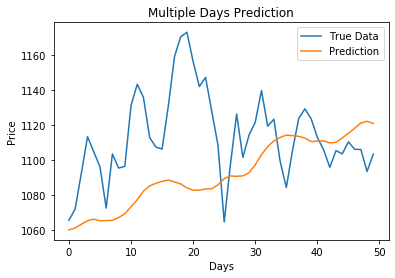

65


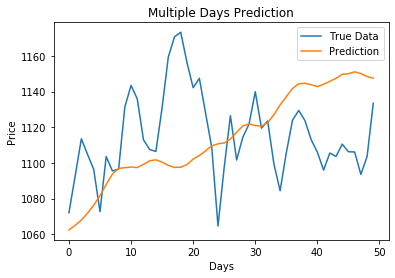

66


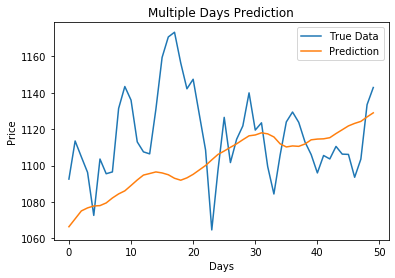

67


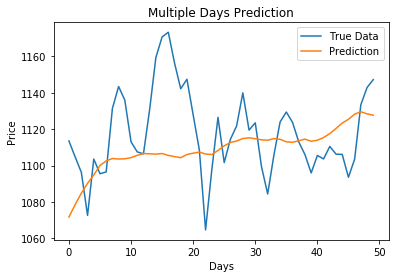

68


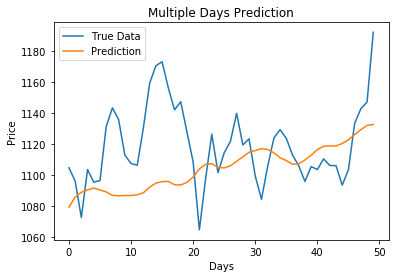

69


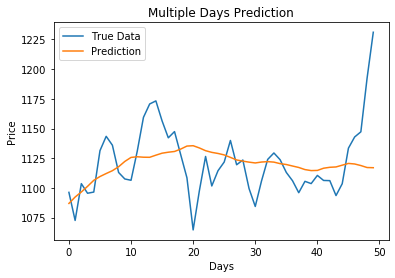

70


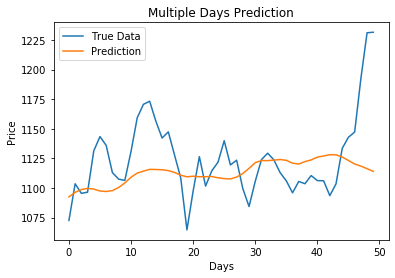

71


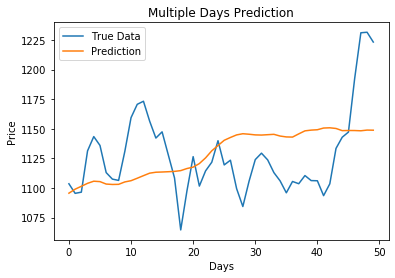

72


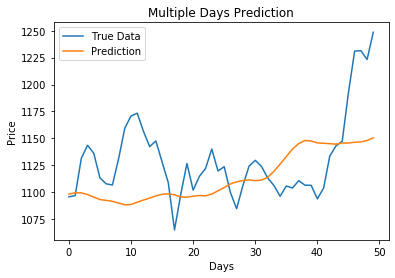

73


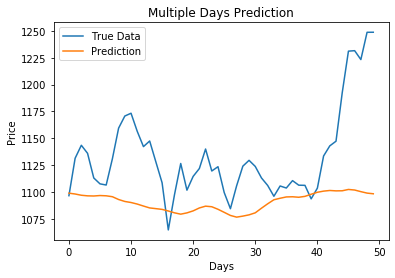

74


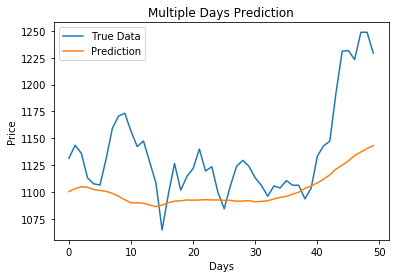

75


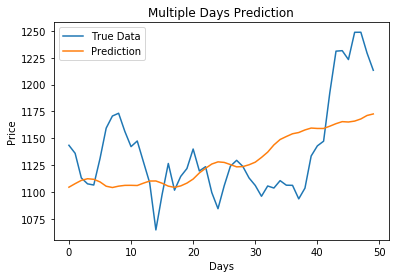

76


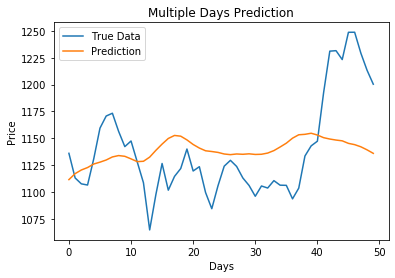

77


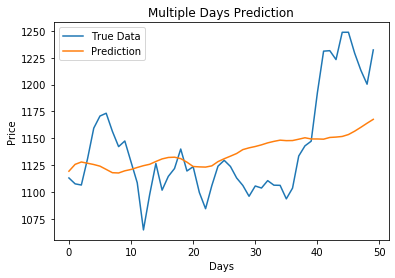

78


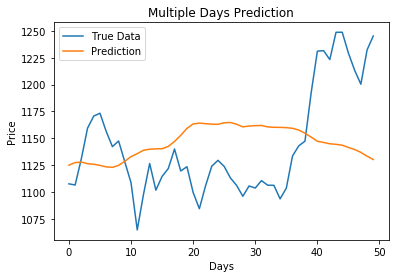

79


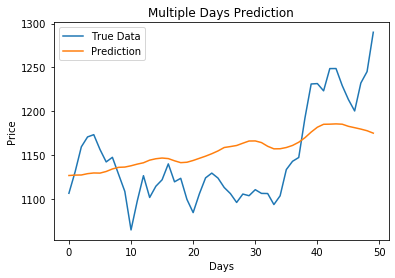

80


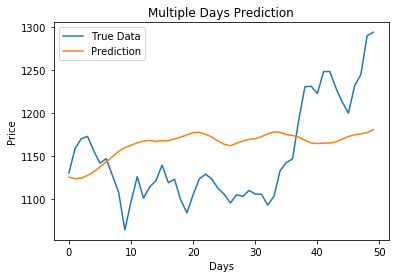

81


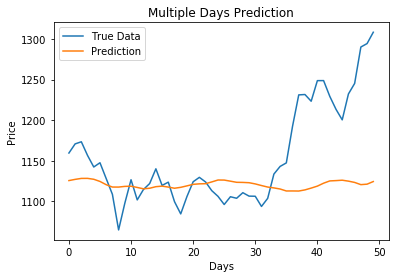

82


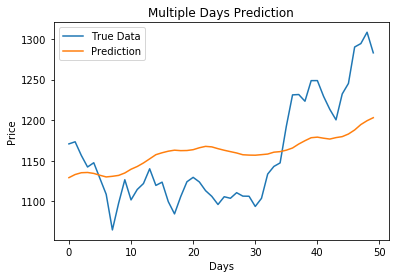

83


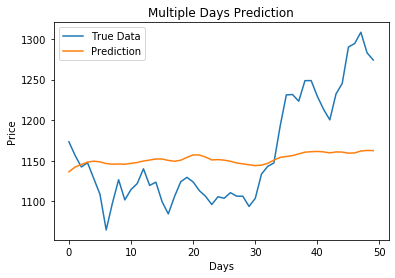

84


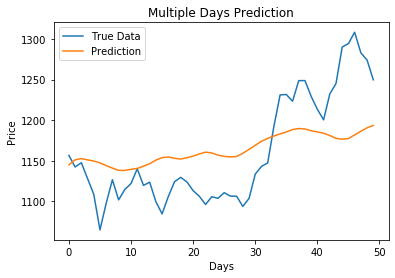

85


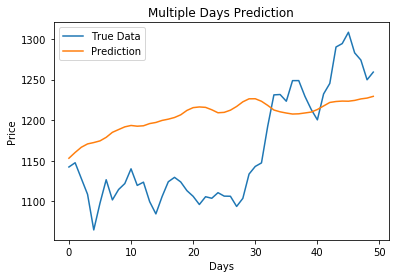

86


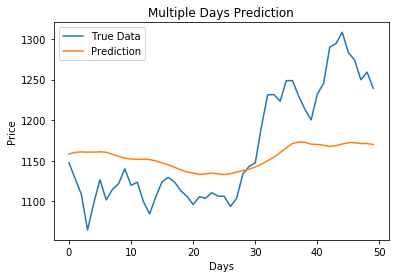

87


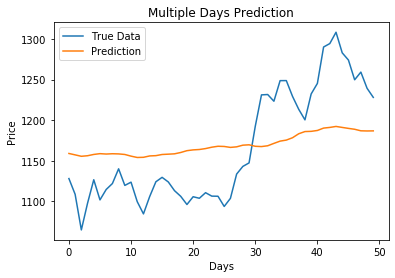

88


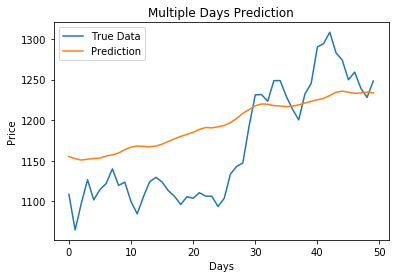

89


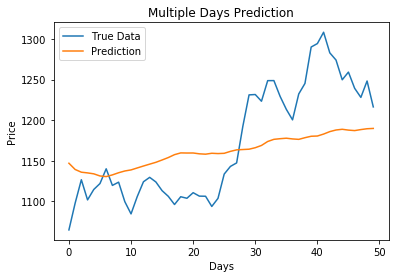

90


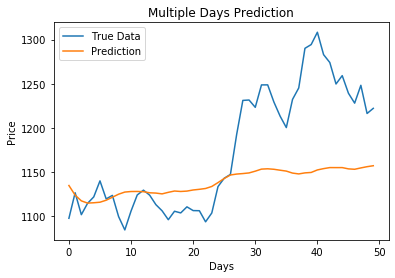

91


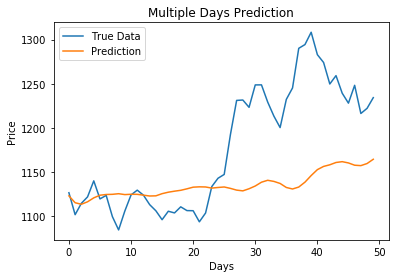

92


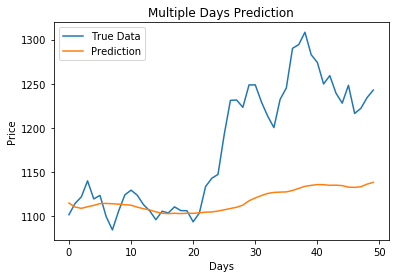

93


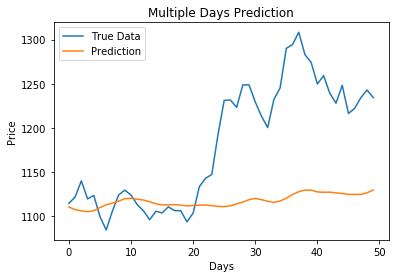

94


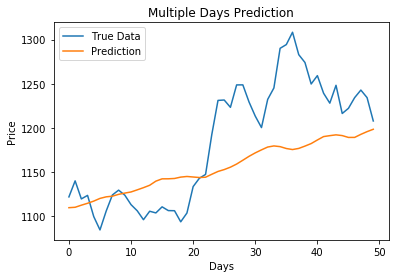

95


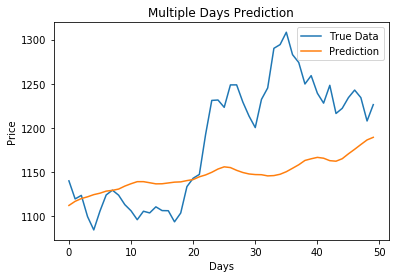

96


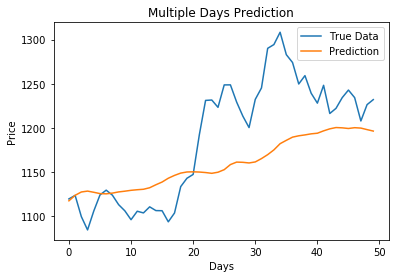

97


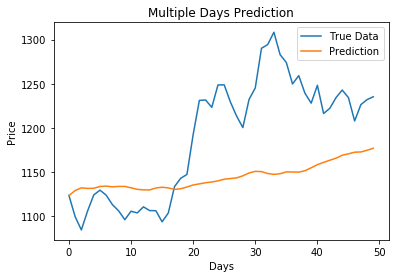

98


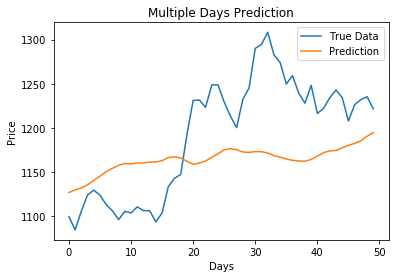

99


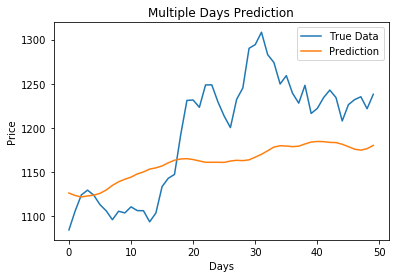

In [19]:
for d in range (100):
    prediction_seqs = np.array(prediction_seqs)
    y_actual = np.array(y_actual)
    size = 15
    print(d)
    plot_results(prediction_seqs[d]*std+mean ,y_actual[d]*std+mean , "Multiple Days Prediction" )

In [83]:
predict*std[0]+mean[0]

array([1079.6364, 1067.588 , 1061.6692, 1060.5848, 1062.6232, 1064.4694,
       1066.6624, 1068.1067, 1069.5447, 1070.3842, 1070.9445, 1072.304 ,
       1073.6708, 1074.9346, 1076.1139, 1077.2706, 1078.4292, 1079.6066,
       1080.7952, 1081.9924, 1083.1862, 1084.3672, 1085.5464, 1086.7275,
       1087.9102, 1089.0928, 1090.2744, 1091.4547, 1092.6339, 1093.8121,
       1094.9897, 1096.1666, 1097.3427, 1098.5177, 1099.6918, 1100.8649,
       1102.0369, 1103.2078, 1104.3778, 1105.5466, 1106.7142, 1107.8807,
       1109.046 , 1110.2101, 1111.3728, 1112.5343, 1113.6945, 1114.8533,
       1116.0106, 1117.1666], dtype=float32)

In [13]:
def avg_loss(loss):
    loss = np.array(loss)
    return np.average(loss ,axis=0)

In [14]:
avgloss = avg_loss(loss)

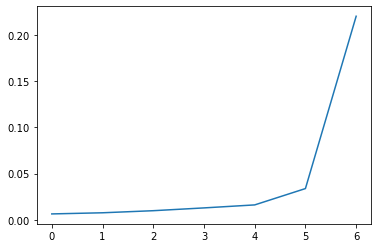

In [16]:
print_loss = []
print_loss.append(avgloss[0])
print_loss.append(avgloss[1])
print_loss.append(avgloss[2])
print_loss.append(avgloss[3])
print_loss.append(avgloss[4])
print_loss.append(avgloss[9])
print_loss.append(avgloss[49])

plt.plot(print_loss)

In [18]:
np.save("output/lstmg10/gru10",avgloss)

In [20]:
model.save_weights("output/lstmg10/model.h5")

In [51]:
mean = np.load("data/mean.npy")
std =np.load("data/std.npy")

In [52]:
mean[0]

979.234331842054

In [55]:
np.array(predict)*std[0]

array([138.40817, 140.0807 , 141.2484 , 141.71892, 142.38716, 143.0173 ,
       144.1509 , 145.63269, 146.94289, 148.01663, 149.09894, 150.18614,
       151.3218 , 152.47813, 153.6276 , 154.7658 , 155.88951, 157.00851,
       158.132  , 159.25822, 160.38191, 161.5023 , 162.61923, 163.73378,
       164.84653, 165.95744, 167.06639, 168.1731 , 169.2772 , 170.37892,
       171.47842, 172.5755 , 173.67026, 174.76254, 175.85243, 176.9397 ,
       178.0245 , 179.10674, 180.18642, 181.26343, 182.3378 , 183.40953,
       184.47856, 185.54488, 186.60838, 187.6691 , 188.72705, 189.78221,
       190.83443, 191.88371, 192.93013, 193.97354, 195.01405, 196.0515 ,
       197.08592, 198.11732, 199.14557, 200.17067, 201.19272, 202.21155,
       203.22725, 204.23969, 205.24889, 206.2548 , 207.25752, 208.25679,
       209.25279, 210.24551, 211.23471, 212.22057, 213.20299, 214.18192,
       215.15744, 216.12944, 217.09784, 218.06282, 219.02419, 219.98193,
       220.93611, 221.88669, 222.83359, 223.77686, 

In [33]:
test_data = pd.read_csv("test_Data")

In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
Unnamed: 0    10 non-null int64
Open          10 non-null float64
High          10 non-null float64
Low           10 non-null float64
Close         10 non-null float64
Unnamed: 5    0 non-null float64
Unnamed: 6    0 non-null float64
Unnamed: 7    0 non-null float64
dtypes: float64(7), int64(1)
memory usage: 768.0 bytes


In [36]:
test_data.drop(columns=["Unnamed: 0","Unnamed: 5","Unnamed: 6","Unnamed: 7"] , inplace=True)

In [37]:
X_test = test_data.values

In [38]:
X_test.shape

(10, 4)

In [22]:
X_test = np.reshape(X_test , (1,10,4))

In [29]:
predictions = predict_point_by_point(model , X_test)

[Model] Predicting Point-by-Point...


In [30]:
predictions

array([2.511999], dtype=float32)

In [39]:
print(X_test)

[[2138.   2138.45 2100.1  2103.25]
 [2125.   2131.   2070.   2110.75]
 [2127.75 2280.   2127.75 2251.55]
 [2299.   2320.   2210.   2254.85]
 [2274.   2292.2  2221.   2269.85]
 [2284.   2284.   2248.   2275.1 ]
 [2300.   2323.   2270.   2300.55]
 [2308.95 2325.9  2289.   2318.55]
 [2319.   2344.5  2291.4  2327.8 ]
 [2339.55 2356.   2321.   2347.5 ]]


In [54]:
mean = np.load("data/mean.npy")
std =np.load("data/std.npy")

In [27]:
X_test =( X_test - mean )/std

In [32]:
2.511999 * std[3] + mean[3]

2355.3046706612336

## Performance Measures
### multiple days predictions

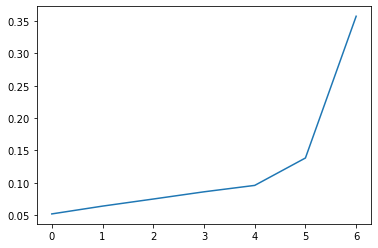

In [135]:
# Mean Aboslute Error
def MeanAbsoluteError(loss):
    loss = np.array(loss)
    loss = loss**(0.5)
    loss = np.array(loss)
    avgloss =  np.average(loss ,axis=0)
    
    print_loss = []
    print_loss.append(avgloss[0])
    print_loss.append(avgloss[1])
    print_loss.append(avgloss[2])
    
    print_loss.append(avgloss[3])
    print_loss.append(avgloss[4])
    print_loss.append(avgloss[9])
    print_loss.append(avgloss[49])
  
    plt.plot(print_loss)
    return avgloss

mae  = MeanAbsoluteError(loss)


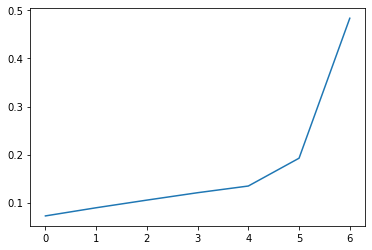

In [136]:
# root mean squared error
def rms(loss):
    loss = np.array(loss)
    print_loss = []
    avgloss = np.sqrt ( np.average(loss ,axis=0))    
    print_loss.append(avgloss[0])
    print_loss.append(avgloss[1])
    print_loss.append(avgloss[2])
    print_loss.append(avgloss[3])
    print_loss.append(avgloss[4])
    print_loss.append(avgloss[9])
    print_loss.append(avgloss[49])
  
    plt.plot(print_loss)
    return avgloss
rms = rms(loss)

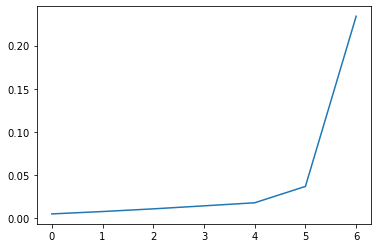

In [137]:
# mean squared error
def mse(loss):
    loss = np.array(loss)
    print_loss = []
    avgloss = np.average(loss ,axis=0)   
    print_loss.append(avgloss[0])
    print_loss.append(avgloss[1])
    print_loss.append(avgloss[2])
    print_loss.append(avgloss[3])
    print_loss.append(avgloss[4])
    print_loss.append(avgloss[9])
    print_loss.append(avgloss[49])
  
    plt.plot(print_loss)
    return avgloss
mse = mse(loss)

In [138]:
# r2 score
from sklearn.metrics import mean_squared_error , r2_score
import math
def r2square(ytest , ypred) :
    ytest = np.array(ytest)
    ypred = np.array(ypred)
    loss =[]
    for i in range (50):
        loss.append(r2_score(ytest[:,i] , ypred[:,i]) )
    return loss
r2 = r2square(y_actual , prediction_seqs)
print(r2)

[0.9326519741019633, 0.8980176856030052, 0.8599465656452737, 0.8194138328347049, 0.7789825169875029, 0.7381922800634076, 0.6975862317017145, 0.6574042143487371, 0.6172769944375612, 0.5783368682515282, 0.5394709952101491, 0.5018842499768984, 0.46561323835979107, 0.4304952744441838, 0.3977336877456269, 0.36694886198134136, 0.3389216022650652, 0.31351218988293283, 0.2904614764440936, 0.26837298475259497, 0.24788510959005983, 0.22828860135214435, 0.21018827514873584, 0.194539121162973, 0.1790605531796008, 0.1643303498036367, 0.15051553372746584, 0.138157150588066, 0.12941442689501137, 0.1209033507982663, 0.11274746947213055, 0.10337989014764482, 0.0943775223039014, 0.08361214917417836, 0.07185225927325056, 0.06301736742931963, 0.053869691456675084, 0.043994309222106454, 0.03474743602225827, 0.02450873828378264, 0.014008576469785483, 0.003883426971412862, -0.006218117918631139, -0.01700659997346743, -0.02876575728356845, -0.04097472307298289, -0.054461535487590806, -0.06622276949064276, -0.

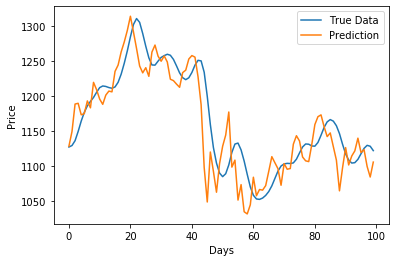

In [139]:
mean = np.load("data/mean.npy")[3]
std =np.load("data/std.npy")[3]

x_c =x_test
y_c = y_test
predictions = model.predict( x_c)

npPredictions = np.asarray(predictions)


real_y = np.reshape(y_c, (y_c.shape[0], ))*std + mean
real_pred = predictions*std +mean

plot_results(real_y[:100], real_pred[:100])


In [140]:
length  = 10
def save_performance():
    np.save("seq_len/"+ str(length)+ "/r2",r2)
    np.save("seq_len/"+ str(length)+"/mse",mse)
    np.save("seq_len/"+ str(length)+"/rms",rms)
    np.save("seq_len/"+ str(length)+"/mae",mae)
    np.save("seq_len/"+ str(length)+"/pred_seqs",prediction_seqs)
    np.save("seq_len/"+ str(length)+"/actual_seqs",y_actual)
    np.save("seq_len/"+ str(length)+"/real_pred",real_pred)
    np.save("seq_len/"+ str(length)+"/real_y",real_y)

In [54]:
mse[49]

0.22111825859346215